In [ ]:
import great_expectations as gx
from ydata_profiling import ProfileReport
import pandas as pd
import time as ts 
import os
from great_expectations.data_context.types.base import DataContextConfig, FilesystemStoreBackendDefaults


In [ ]:
#Create context
context_dir = os.path.abspath("./gx-demo")
data_context_config = DataContextConfig(
    store_backend_defaults=FilesystemStoreBackendDefaults(
        root_directory=context_dir),
)
context = gx.get_context(project_config=data_context_config)
with open("./gx-demo/great_expectations.yml", 'w') as outfile:
    context.config.to_yaml(outfile)

We have data set for testing "Titanic" 
Our goal is test the data wuth Great Expectations library

We start from reading the data and prepare data assets for testing

In [ ]:
#read data
df_pandas = pd.read_csv('data/titanic.csv')
suite_name = 'titanic'

#create a data source
datasource = context.sources.add_or_update_pandas(name="pandas")
asset_names = datasource.get_asset_names()

if suite_name not in asset_names:
    data_asset = datasource.add_dataframe_asset(name=suite_name, dataframe=df_pandas)
else:
    data_asset = datasource.build_batch_request(dataframe=df_pandas)

In [ ]:
profile = ProfileReport(df_pandas, title=f"{suite_name} Profiling Report", minimal=True)

In [ ]:
profile.to_file(f"{suite_name}_profile.html")

After profiling we will generate technical tests for the data

In [ ]:
from expectation_report import ExpectationsReportV3
from ydata_profiling.expectations_report import ExpectationsReport


ExpectationsReport.to_expectation_suite = ExpectationsReportV3.to_expectation_suite

suite = profile.to_expectation_suite(
    suite_name=suite_name,
    data_context=context,
    run_validation=False,
    build_data_docs=False,
    save_suite=False,
)

context.save_expectation_suite(suite)

Add bussiness tests to new tests suite

In [ ]:
#bussines tests
suite_name = 'titanic_bussines_tests'
bussiness_suite = context.add_or_update_expectation_suite(expectation_suite_name=suite_name)

In [ ]:
from great_expectations.core.expectation_configuration import (
    ExpectationConfiguration,
)
expectation_configuration = ExpectationConfiguration(
    expectation_type="expect_column_unique_value_count_to_be_between",
    kwargs={
        "column": "name",
        "min_value": 79,
        "max_value": 79,
    },
)
bussiness_suite.add_expectation(
    expectation_configuration=expectation_configuration
)

In [ ]:
context.save_expectation_suite(expectation_suite=bussiness_suite)

***Checkpoint***

Checkpoints validate data, save Validation Results, run any Actions you have specified, and finally, create Data Docs with their results.

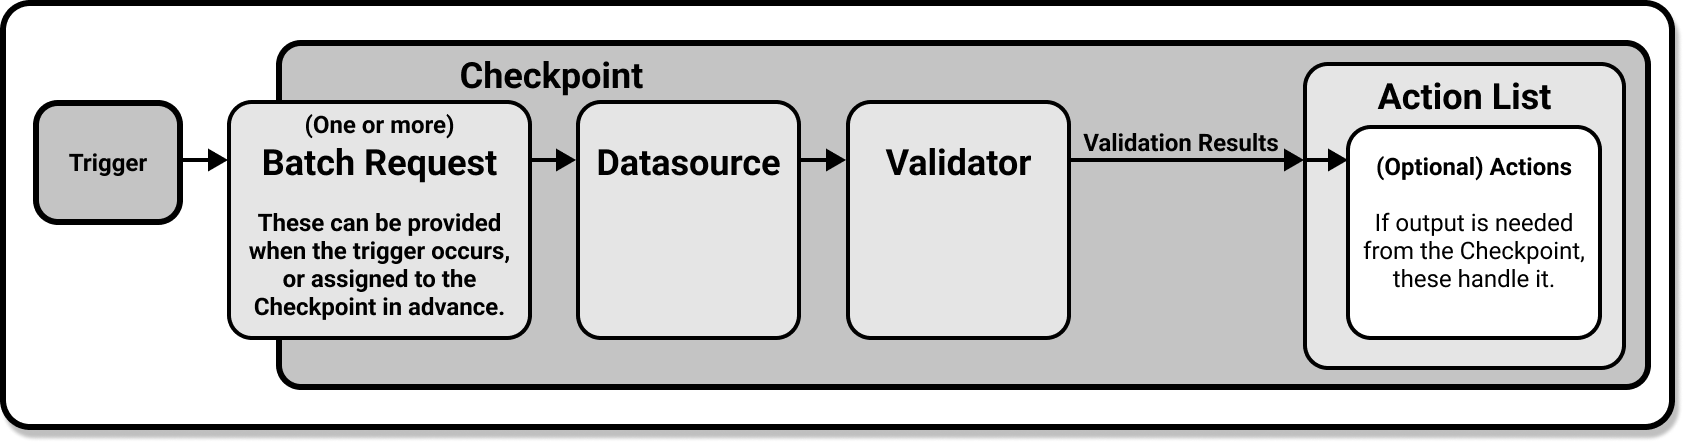

In [ ]:
data_asset = datasource.get_asset(asset_name='titanic')
batch_request = data_asset.build_batch_request(dataframe=df_pandas)
checkpoint = context.add_or_update_checkpoint(
    name="my_checkpoint",
    validations=[
        {
            "batch_request": batch_request,
            "expectation_suite_name": "titanic_bussines_tests",
        },
        {
            "batch_request": batch_request,
            "expectation_suite_name": "titanic",
        },
    ],
)

In [ ]:
#RUN CHECKPOINT
run_name = f"smoke_run_{ts.time()}"
checkpoint.run(run_name=run_name)

Image that we have a new data set and we want to validate it. 

In [ ]:
new_data_set = pd.read_csv('data/titanic_copy.csv')
batch_request = data_asset.build_batch_request(dataframe=new_data_set)
checkpoint = context.get_checkpoint(name="my_checkpoint")

run checkpoint for new data and build data docs

In [ ]:

run_id = ts.time()
checkpoint.run(run_name=f"CDC_{run_id}")
context.build_data_docs()
context.open_data_docs()